# Řešení problému batohu pomocí evolučních algoritmů

In [177]:
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Zobrazení progress baru

def start_progress(size, every=1, title=''):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    title_label = HTML()
    title_label.value = title;
    box = VBox(children=[title_label, label, progress])
    display(box)
    return (box, label, progress, size, every, 1)

def add_progress(logger):
    box, label, progress, size, every, index = logger
    if index % every == 0: 
        progress.value = index
        label.value = u'{index} / {size}'.format(index=index,size=size)
    if index==size:
        box.close()
    return (box, label, progress, size, every, index + 1)

In [160]:

def init_genome():
    return np.random.randint(0,2,size=GENOME_SIZE).astype(np.bool)

def init_population():
    global POPULATION, FITNESS
    POPULATION = np.ndarray((POPULATION_SIZE, GENOME_SIZE),dtype=np.bool)
    FITNESS = np.zeros(POPULATION_SIZE)
    for i in range(0, POPULATION_SIZE):
        POPULATION[i] = init_genome()
        FITNESS[i] = calculate_fitness(POPULATION[i])

def mutate(genome):
    rand_index = np.random.randint(genome.size)
    child = genome.copy()
    child[rand_index] = not child[rand_index]
    return child
    
def crossover(genome1, genome2):
    a_index = np.random.randint(genome1.size)
    b_index = np.random.randint(genome1.size)
    start_index = min(a_index, b_index)
    stop_index = max(a_index, b_index)
    
    if a_index < b_index: # flip genomes
        foo = genome1
        genome1 = genome2
        genome2 = foo
        
    child = genome1.copy()
    for i in range(start_index, stop_index):
        child[i] = genome2[i]
    return child
    
def select(method='tournament'):
    global POPULATION, FITNESS
    start_index = 0
    new_population = np.ndarray((POPULATION_SIZE, GENOME_SIZE),dtype=np.bool)
    new_fitness = np.zeros(POPULATION_SIZE)
    if ELITISM_COUNT:
        elites = np.argpartition(FITNESS, -ELITISM_COUNT)[-ELITISM_COUNT:]
        for i in range(0, ELITISM_COUNT):
            new_population[i] = POPULATION[elites[i]]
            new_fitness[i] = FITNESS[elites[i]]
            
    if method=='tournament':
        for i in range(ELITISM_COUNT, POPULATION_SIZE):
            choices = np.random.choice(POPULATION_SIZE, TOURNAMENT_SIZE)
            fitness = FITNESS[choices]
            #nans = np.where(np.isnan(fitness))[0]
            #if nans.size:
            #    fitness[nans] = np.apply_along_axis(calculate_fitness, 1, POPULATION[choices][nans])
            #    FITNESS[choices] = fitness
            best = choices[np.argmax(fitness)]
            new_population[i] = POPULATION[best]
            new_fitness[i] = FITNESS[best]
        POPULATION = new_population
        FITNESS = new_fitness
    else:
        raise Exception('Method {} not implemented'.format(method))
    
def mutate_and_crossover(start_index=0):
    for i in range(ELITISM_COUNT, POPULATION_SIZE):
        mutate_rand = np.random.random_sample()
        crossover_rand = np.random.random_sample()
        if mutate_rand < MUTATION_PROBABILITY:
            POPULATION[i] = mutate(POPULATION[i])
            FITNESS[i] = calculate_fitness(POPULATION[i])
        if crossover_rand < CROSSOVER_PROBABILITY:
            random_partner = np.random.randint(POPULATION_SIZE)
            POPULATION[i] = crossover(POPULATION[i], POPULATION[random_partner])
            FITNESS[i] = calculate_fitness(POPULATION[i])
            
def get_results():
    return {'min':np.min(FITNESS), 'avg':np.mean(FITNESS), 'max':np.max(FITNESS)}


def generation_step():
    select()
    mutate_and_crossover()



In [208]:
from IPython.display import clear_output

RESULTS = None
def evolution_start():
    global RESULTS
    init_population()
    RESULTS = pd.DataFrame()

def evolution_step():
    global RESULTS
    generation_step()
    RESULTS = RESULTS.append(get_results(), ignore_index=True)
    
def evolution_results():
    clear_output()
    fig, ax = plt.subplots(ncols=2, figsize=(15,4))
    RESULTS[['max','avg','min']].plot(ax=ax[0])
    best = RESULTS['max'].max()
    best_idx = RESULTS['max'].idxmax()
    ax[0].set_xlim(-3, NUM_GENERATIONS)
    ax[0].set_ylim(-1, FITNESS_MAX*1.1)
    ax[0].plot([0,NUM_GENERATIONS],[FITNESS_MAX, FITNESS_MAX])
    ax[1].hist(FITNESS, bins=20)
    plt.show()
    if best == FITNESS_MAX:
        print('Reached optimal solution in {} generations.'.format(best_idx))
    else:
        print('Reached {}% sub-optimal solution in {} generations.'.format(int(best*100/FITNESS_MAX),best_idx))
        

In [201]:
def evolution_run(foo=None):
    global GENOME_SIZE, POPULATION_SIZE, NUM_GENERATIONS, MUTATION_PROBABILITY, CROSSOVER_PROBABILITY, \
            TOURNAMENT_SIZE, ELITISM_COUNT
    GENOME_SIZE = INSTANCE_SIZE
    POPULATION_SIZE = POPULATION_SIZE_slider.value
    NUM_GENERATIONS = NUM_GENERATIONS_slider.value
    MUTATION_PROBABILITY = MUTATION_PROBABILITY_slider.value
    CROSSOVER_PROBABILITY = CROSSOVER_PROBABILITY_slider.value
    TOURNAMENT_SIZE = TOURNAMENT_SIZE_slider.value
    ELITISM_COUNT = ELITISM_COUNT_slider.value

    evolution_start() 
    for i in range(0, NUM_GENERATIONS):
        evolution_step()  
    evolution_results()

In [202]:
import ipywidgets as widgets

items = []

POPULATION_SIZE_slider = widgets.IntSlider(value=100,min=10,max=1000,step=10,description='Population size:')
items.append(POPULATION_SIZE_slider)

NUM_GENERATIONS_slider = widgets.IntSlider(value=100,min=10,max=5000,step=10,description='Number of generations:')
items.append(NUM_GENERATIONS_slider)

TOURNAMENT_SIZE_slider = widgets.IntSlider(value=3,min=1,max=50,step=1,description='Tournament size:')
items.append(TOURNAMENT_SIZE_slider)

ELITISM_COUNT_slider = widgets.IntSlider(value=3,min=0,max=50,step=1,description='Elitism count:')
items.append(ELITISM_COUNT_slider)

MUTATION_PROBABILITY_slider = widgets.FloatSlider(value=0.3,min=0,max=1,step=0.05,description='Mutation probability:')
items.append(MUTATION_PROBABILITY_slider)

CROSSOVER_PROBABILITY_slider = widgets.FloatSlider(value=0.1,min=0,max=1,step=0.05,description='Crossover probability:')
items.append(CROSSOVER_PROBABILITY_slider)

button_run = widgets.Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    icon='play'
)
button_run.on_click(evolution_run)
items.append(button_run)

# Knapsack problem

## Exhaustive algorithm

In [120]:
# Dynamic programming
# Decomposition by weight

DYN_SOLUTIONS_PRICE = None
DYN_SOLUTIONS_ARR = None
def solve_knapsack_dyn_recursive(ID, n, M, weights, prices, price=0, weight=0, solution=None):
    global DYN_SOLUTIONS_PRICE, DYN_SOLUTIONS_ARR
    #print(solution)
    if weight > M:
        return -1, [], 1
    if n==0:
        return price, solution, 1
    first = False
    if solution is None:
        DYN_SOLUTIONS_PRICE = np.full((n,M+1), -1, dtype=np.int)
        DYN_SOLUTIONS_ARR = np.ndarray((n,M+1), dtype=object)
        solution = []
        first = True
    else:
        solution_price = DYN_SOLUTIONS_PRICE[n, weight]
        if solution_price != -1:
            solution_arr = DYN_SOLUTIONS_ARR[n, weight]
            #print('Get ',n, weight, ':', (solution_price, solution_arr))
            #print('    ',n, weight, ':', (price+solution_price, solution+solution_arr))
            return (price+solution_price, solution+solution_arr, 1)
        
    #print(DYN_SOLUTIONS_ARR[n-1, weight-1])
    left, left_solution, left_steps = solve_knapsack_dyn_recursive(ID, n-1, M, weights[1:], prices[1:], price+prices[0], weight+weights[0], solution+[1])
    right, right_solution, right_steps = solve_knapsack_dyn_recursive(ID, n-1, M, weights[1:], prices[1:], price, weight, solution+[0])
    steps = left_steps + right_steps
    result = (right, right_solution, steps)
    if left >= right:
        result = (left, left_solution, steps)
    if not first:
        DYN_SOLUTIONS_PRICE[n, weight] = result[0]-price
        DYN_SOLUTIONS_ARR[n, weight] = result[1][-n:]
        #print('Setting ',n,weight, ':', result)
    return result

## Loading instances 

In [123]:
instances = []
for instance_size in [30,32,35,37]:
    with open('inst/knap_{}.inst.dat'.format(instance_size), 'rb') as f:
        reader = csv.reader(f,delimiter=' ')
        for row in reader:
            ID = '{}_{}'.format(instance_size, row[0])
            n = int(row[1])
            M = int(row[2])
            weights = [int(row[i]) for i in range(3,len(row)-1,2)]
            prices = [int(row[i+1]) for i in range(3,len(row)-1,2)]
            correct, solution, steps = solve_knapsack_dyn_recursive(ID, n, M, weights, prices) 
            instances.append({'ID':ID, 'n':n, 'M':M, 'weights':weights,'prices':prices,'correct':correct})
instances = pd.DataFrame(instances)
instances.head()

,ID,M,correct,n,prices,weights
0,30_9350,400,2875,30,"[61, 24, 31, 73, 92, 168, 65, 4, 54, 165, 17, ...","[22, 28, 1, 6, 38, 5, 11, 20, 46, 3, 32, 14, 4..."
1,30_9351,400,3327,30,"[17, 155, 128, 204, 171, 255, 30, 184, 12, 132...","[14, 22, 2, 42, 26, 5, 1, 17, 12, 4, 20, 15, 6..."
2,30_9352,400,3463,30,"[130, 136, 202, 120, 115, 7, 15, 151, 235, 236...","[41, 37, 2, 1, 15, 6, 7, 3, 5, 33, 16, 11, 4, ..."
3,30_9353,400,3987,30,"[81, 65, 208, 2, 79, 253, 189, 142, 42, 28, 22...","[34, 13, 1, 3, 15, 4, 20, 5, 2, 19, 8, 16, 11,..."
4,30_9354,400,3771,30,"[230, 145, 93, 25, 206, 178, 8, 187, 108, 190,...","[20, 36, 11, 35, 12, 4, 1, 29, 14, 5, 15, 2, 3..."


In [164]:
def update_fitness_calculator(instance):
    global calculate_fitness, GENOME_SIZE, FITNESS_MAX
    
    FITNESS_MAX = instance.correct
    GENOME_SIZE = instance.n
    M = instance.M
    nprices = np.array(instance.prices)
    nweights = np.array(instance.weights)
    
    def calculator(genome):
        price = nprices[genome].sum()
        weight = nweights[genome].sum()
        if weight <= M:
            return price
        return -float(weight)/price
        
    calculate_fitness = calculator

In [203]:
update_fitness_calculator(instance)

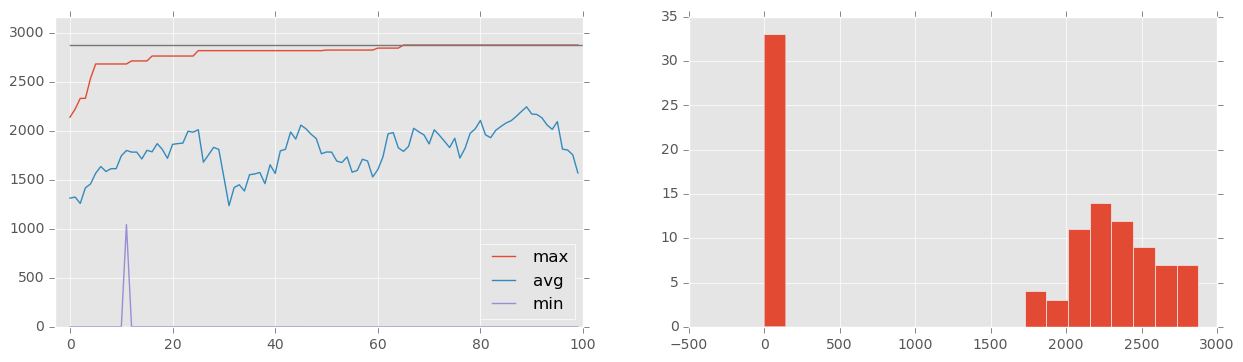

Reached optimal solution in 65 generations.


In [209]:
widgets.VBox(items)

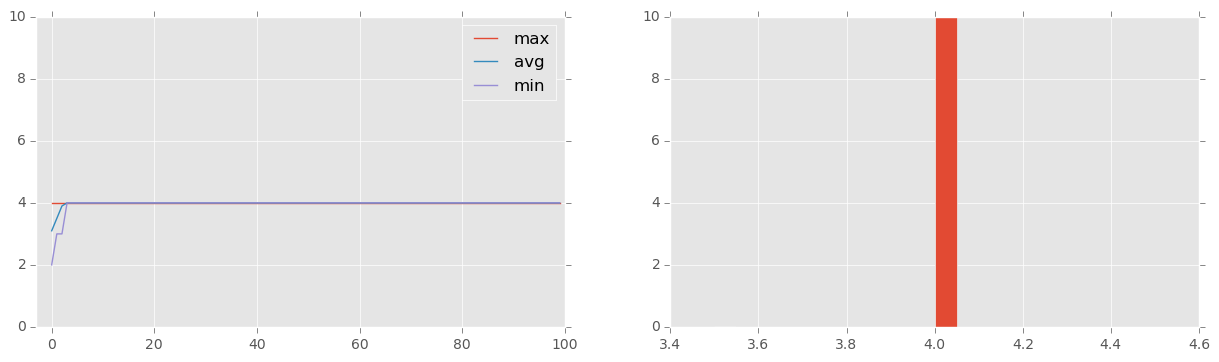

In [68]:

evolution_results()

In [27]:
POPULATION = None
FITNESS = None

button_play = widgets.Play(
    interval=1000,
    value=0,
    min=0,
    max=NUM_GENERATIONS,
    step=1,
    description="Press play",
    disabled=True
)

play_slider = widgets.IntSlider()
play_slider.observe(evolution_play, 'value')
widgets.jslink((button_play, 'value'), (play_slider, 'value'))


evolution_play(None)
button_play.value = 1
evolution_play(None)

widgets.VBox([widgets.HBox([button_play, play_slider]), fig])

bqplot.figure.Figure

In [36]:
button_play.value = 0
evolution_play(None)
button_play.value = 1
evolution_play(None)
button_play.value = 2
evolution_play(None)

0
[ 4.  3.  3.  2.  4.  3.  3.  3.  3.  2.]
1
[ 3.  4.  4.  4.  4.  3.  2.  4.  4.  4.]
2


In [ ]:
def xx(dd):
    print(dd)

In [ ]:
button_play